In [ ]:
import kagglehub

path = kagglehub.dataset_download("naumisharanyatirth/ip-data-science-bowl-2018")

print("Dataset path:", path)


100%|██████████| 368M/368M [00:13<00:00, 28.9MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/naumisharanyatirth/ip-data-science-bowl-2018/versions/1


In [ ]:
import os

print(os.listdir(path))


['stage1_train', 'stage2_sample_submission_final.csv', 'stage2_test_final', 'stage1_solution.csv', 'stage1_sample_submission.csv', 'stage1_train_labels.csv', 'stage1_test']


In [ ]:
import os

train_path = os.path.join(path, "stage1_train")
print("Total training samples:", len(os.listdir(train_path)))


Total training samples: 670


In [ ]:
sample_id = image_ids[0]

sample_path = os.path.join(train_path, sample_id)

print("Inside sample folder:")
print(os.listdir(sample_path))

print("\nInside images folder:")
print(os.listdir(os.path.join(sample_path, "images")))

print("\nNumber of masks:")
print(len(os.listdir(os.path.join(sample_path, "masks"))))


Inside sample folder:
['images', 'masks']

Inside images folder:
['93cfd412c7de5210bbd262ec3a602cfea65072e9272e9fce9b5339a5b9436eb7.png']

Number of masks:
6


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [28]:
def watershed_without_markers(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Create simple markers from threshold directly
    markers = thresh.copy()
    markers = cv2.connectedComponents(markers)[1]

    markers = markers + 1

    markers = cv2.watershed(image, markers)

    mask = np.zeros_like(gray)
    mask[markers > 1] = 255

    return mask


In [29]:
def watershed_with_markers(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    _, sure_fg = cv2.threshold(
        dist_transform,
        0.5 * dist_transform.max(),
        255, 0
    )

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)

    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)

    mask = np.zeros_like(gray)
    mask[markers > 1] = 255

    return mask


In [30]:
for img_id in tqdm(image_ids):

    img_path = os.path.join(train_path, img_id, "images", img_id + ".png")
    mask_dir = os.path.join(train_path, img_id, "masks")

    image = cv2.imread(img_path)
    if image is None:
        continue

    # Ground Truth Combine
    mask_files = os.listdir(mask_dir)
    gt_mask = None

    for m in mask_files:
        m_img = cv2.imread(os.path.join(mask_dir, m), 0)
        if gt_mask is None:
            gt_mask = np.zeros_like(m_img)
        gt_mask[m_img > 0] = 255

    # WITHOUT markers
    pred1 = watershed_without_markers(image)

    # WITH markers
    pred2 = watershed_with_markers(image)

  0%|          | 0/670 [00:00<?, ?it/s]

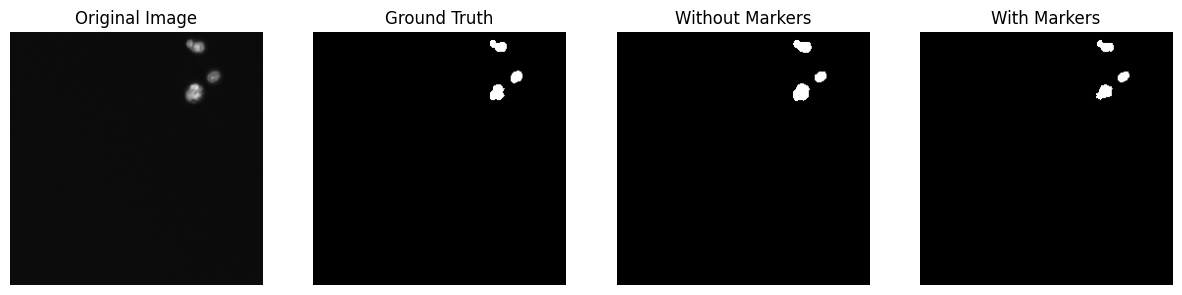

In [32]:
import matplotlib.pyplot as plt

# pick one image
sample_id = image_ids[0]

img_path = os.path.join(train_path, sample_id, "images", sample_id + ".png")
mask_dir = os.path.join(train_path, sample_id, "masks")

image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# combine GT masks
mask_files = os.listdir(mask_dir)
gt_mask = None

for m in mask_files:
    m_img = cv2.imread(os.path.join(mask_dir, m), 0)
    if gt_mask is None:
        gt_mask = np.zeros_like(m_img)
    gt_mask[m_img > 0] = 255

# predictions
pred_without = watershed_without_markers(image)
pred_with = watershed_with_markers(image)

# plot
plt.figure(figsize=(15,8))

plt.subplot(1,4,1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(pred_without, cmap="gray")
plt.title("Without Markers")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(pred_with, cmap="gray")
plt.title("With Markers")
plt.axis("off")

plt.show()
